In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
#from train1 import train_model
#from model_utils import *
#from predict_utils import *
#from vis_utils import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [5]:
# Our libraries
from train1 import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

In [6]:
use_gpu

True

In [7]:
DATA_DIR = './fruits-360/'
sz = 224
batch_size = 16

In [8]:
os.listdir(DATA_DIR)

['LICENSE', 'readme.md', 'Training', 'Test', 'test-multiple_fruits', 'papers']

In [9]:
trn_dir = f'{DATA_DIR}Training'
val_dir = f'{DATA_DIR}Test'
#test_dir = f'{DATA_DIR}val'

In [10]:
os.listdir(trn_dir)

['Lychee',
 'Pomegranate',
 'Grape White 4',
 'Nectarine',
 'Granadilla',
 'Papaya',
 'Cantaloupe 2',
 'Rambutan',
 'Chestnut',
 'Pear Williams',
 'Avocado ripe',
 'Grape White 3',
 'Apple Red Yellow 2',
 'Strawberry Wedge',
 'Lemon',
 'Walnut',
 'Grape Blue',
 'Carambula',
 'Apple Red Delicious',
 'Tomato 1',
 'Apple Granny Smith',
 'Apple Red 2',
 'Grapefruit Pink',
 'Apricot',
 'Mandarine',
 'Tomato 3',
 'Cherry 2',
 'Clementine',
 'Huckleberry',
 'Plum 2',
 'Tomato 2',
 'Kaki',
 'Banana Red',
 'Cactus fruit',
 'Cherry Wax Red',
 'Peach',
 'Grape White 2',
 'Apple Red 3',
 'Strawberry',
 'Melon Piel de Sapo',
 'Kumquats',
 'Pepino',
 'Cherry 1',
 'Passion Fruit',
 'Peach 2',
 'Tomato Cherry Red',
 'Apple Golden 2',
 'Cantaloupe 1',
 'Cherry Rainier',
 'Pear Abate',
 'Pear Kaiser',
 'Quince',
 'Apple Red Yellow 1',
 'Peach Flat',
 'Raspberry',
 'Lemon Meyer',
 'Pitahaya Red',
 'Avocado',
 'Mulberry',
 'Tangelo',
 'Mango',
 'Grape Pink',
 'Pineapple Mini',
 'Physalis',
 'Pomelo Sweeti

In [11]:
os.listdir(val_dir)

['Lychee',
 'Pomegranate',
 'Grape White 4',
 'Nectarine',
 'Granadilla',
 'Papaya',
 'Cantaloupe 2',
 'Rambutan',
 'Chestnut',
 'Pear Williams',
 'Avocado ripe',
 'Grape White 3',
 'Apple Red Yellow 2',
 'Strawberry Wedge',
 'Lemon',
 'Walnut',
 'Grape Blue',
 'Carambula',
 'Apple Red Delicious',
 'Tomato 1',
 'Apple Granny Smith',
 'Apple Red 2',
 'Grapefruit Pink',
 'Apricot',
 'Mandarine',
 'Tomato 3',
 'Cherry 2',
 'Clementine',
 'Huckleberry',
 'Plum 2',
 'Tomato 2',
 'Kaki',
 'Banana Red',
 'Cactus fruit',
 'Cherry Wax Red',
 'Peach',
 'Grape White 2',
 'Apple Red 3',
 'Strawberry',
 'Melon Piel de Sapo',
 'Kumquats',
 'Pepino',
 'Cherry 1',
 'Passion Fruit',
 'Peach 2',
 'Tomato Cherry Red',
 'Apple Golden 2',
 'Cantaloupe 1',
 'Cherry Rainier',
 'Pear Abate',
 'Pear Kaiser',
 'Quince',
 'Apple Red Yellow 1',
 'Peach Flat',
 'Raspberry',
 'Lemon Meyer',
 'Pitahaya Red',
 'Avocado',
 'Mulberry',
 'Tangelo',
 'Mango',
 'Grape Pink',
 'Pineapple Mini',
 'Physalis',
 'Pomelo Sweeti

In [12]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.jpg')
trn_fnames[:5]

['./fruits-360/Training/Lychee/r_169_100.jpg',
 './fruits-360/Training/Lychee/r_288_100.jpg',
 './fruits-360/Training/Lychee/0_100.jpg',
 './fruits-360/Training/Lychee/r_73_100.jpg',
 './fruits-360/Training/Lychee/250_100.jpg']

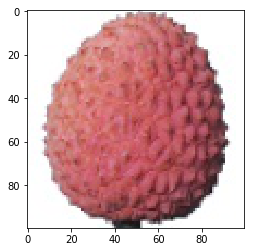

In [13]:
img = plt.imread(trn_fnames[2])
plt.imshow(img);

In [14]:
def evaluate_model(model, dataloader):
    model.eval()  # for batch normalization layers
    corrects = 0
    for inputs, targets in dataloader:
        inputs, targets = to_var(inputs, True), to_var(targets, True)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [15]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(80),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f'{DATA_DIR}Training', train_transforms)
valid_ds = datasets.ImageFolder(f'{DATA_DIR}Test', valid_transforms)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True,num_workers=8)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True,num_workers=8)

train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} ({:.2f})'.format(train_ds_sz, valid_ds_sz, valid_ds_sz/(train_ds_sz + valid_ds_sz)))

class_names = train_ds.classes

Train size: 48905
Valid size: 16421 (0.25)


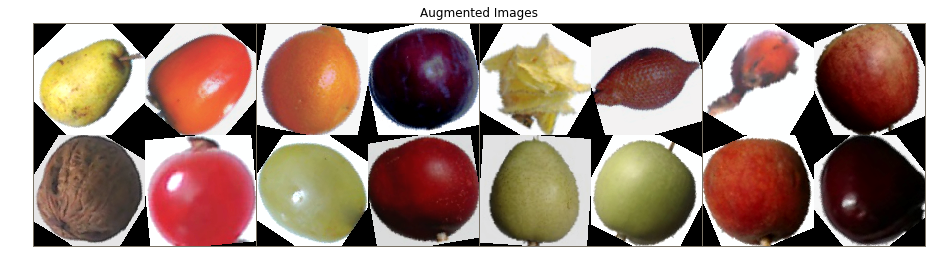

In [16]:
inputs, targets = next(iter(train_dl))     # Get a batch of training data
out = torchvision.utils.make_grid(inputs)  # Make a grid from batch
plt.figure(figsize=(16., 12.))
imshow(out, title='Augmented Images');

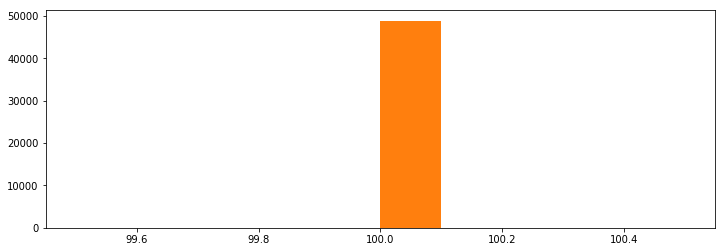

In [17]:
fnames = glob.glob(f'{trn_dir}/*/*.jpg')
sizes = [Image.open(f).size for f in fnames]

hs, ws = list(zip(*sizes))

plt.figure(figsize=(12., 4.))
plt.hist(hs)
plt.hist(ws);

In [18]:

model = load_pretrained_resnet50(model_path=None, num_classes=95)
if use_gpu:
    model = model.cuda()

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [19]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs=5)

Epoch 1/5
----------
  train Loss: 0.22102 Acc: 0.95526
  Step 3/1026 | Loss: 0.00770

/home/kian/Desktop/firut360/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


  valid Loss: 0.00422 Acc: 0.99982

Epoch 2/5
----------
  train Loss: 0.00890 Acc: 0.99922
  valid Loss: 0.00301 Acc: 0.99903

Epoch 3/5
----------
  train Loss: 0.00499 Acc: 0.99943
  valid Loss: 0.00195 Acc: 0.99951

Epoch 4/5
----------
  train Loss: 0.00304 Acc: 0.99969
  valid Loss: 0.00126 Acc: 1.00000

Epoch 5/5
----------
  train Loss: 0.00256 Acc: 0.99973
  valid Loss: 0.00066 Acc: 1.00000

Training complete in 22m 31s
Best val Acc: 1.0000


In [20]:
evaluate_model(model, valid_dl)

/home/kian/Desktop/firut360/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


accuracy: 100.00


/home/kian/Desktop/firut360/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


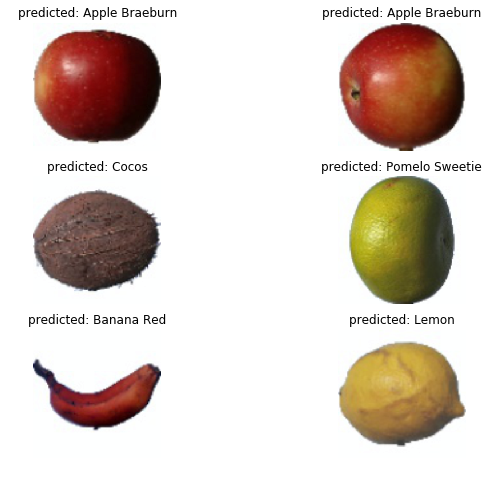

In [21]:
visualize_model(model, valid_dl, num_images=6)

In [22]:
plot_errors(model, valid_dl)

  0%|          | 0/1027 [00:00<?, ?it/s]/home/kian/Desktop/firut360/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)
100%|██████████| 1027/1027 [00:26<00:00, 38.12it/s]


<Figure size 864x1728 with 0 Axes>

0 images out of 16421 were misclassified.
